# Телекоммуникации

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Цель проекта:** Необходимо построить модель для задачи классификации, которая предскажет, уйдет клиент или нет.

**Описание данных:** Четыре датасета, полученных из разных источников: информация о договоре; персональные данные клиента; информация об интернет-услугах; информация об услугах телефонии.


**План работы:**

1 ПРЕДОБРАБОТКА ДАННЫХ

1.1 Импорт библиотек

1.2 Загрузка датасетов, вывод первичной информации о них, проверка уникальных значений

1.3 Промежуточные выводы

2 ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ

2.1 Объединение датасетов

2.2 Постороение графиков зависимостей данных

2.3 Проверка на мультиколлинеарность

2.4 Промежуточные выводы

3 ПОДГОТОВКА К ОБУЧЕНИЮ МОДЕЛЕЙ

3.1 Разбивка на тренировочную и тестовую выборки

3.2 Кодирование признаков

3.3 Масштабирование признаков

3.4 Промежуточные выводы

4 ОБУЧЕНИЕ МОДЕЛЕЙ

4.1 Случайный лес

4.2 Градиентный бустинг

4.3 Логистическая регрессия

4.4 Промежуточные выводы

5 ПРОВЕРКА МОДЕЛИ

5.1 Проверка модели на тестовой выборке

5.2 Промежуточные выводы

6 ОБЩИЙ ВЫВОД

## Предобработка данных

### Импортируем необходимые библиотеки

In [1]:
!pip install phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 8.0 MB/s eta 0:00:00


In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

from catboost import CatBoostClassifier

Зададим дату выгрузки:

In [4]:
data_load = '2020-02-01'

### Загрузим датасеты в соответствующие переменные, выведем их и информацию о них на экран, и проверим уникальные значения

In [5]:
contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')

contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [6]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
contract.value_counts()

customerID  BeginDate   EndDate     Type            PaperlessBilling  PaymentMethod              MonthlyCharges  TotalCharges
0002-ORFBO  2019-05-01  No          One year        Yes               Mailed check               65.60           631.73          1
6616-AALSR  2014-09-01  2017-05-01  Two year        Yes               Credit card (automatic)    104.30          3337.6          1
6625-UTXEW  2019-02-01  No          Month-to-month  Yes               Electronic check           51.25           615.0           1
6625-IUTTT  2014-07-01  No          Two year        No                Bank transfer (automatic)  65.55           4391.85         1
6625-FLENO  2015-04-01  No          Two year        No                Mailed check               20.75           1263.67         1
                                                                                                                                ..
3352-RICWQ  2019-05-01  No          Two year        No                Mailed check      

**Вывод:** Датасет contract содержит 8 столбцов и 7043 строки; пропусков и дубликатов нет.

In [8]:
personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')

personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [9]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [10]:
personal.value_counts()

customerID  gender  SeniorCitizen  Partner  Dependents
0002-ORFBO  Female  0              Yes      Yes           1
6616-AALSR  Female  0              Yes      Yes           1
6625-UTXEW  Female  0              Yes      No            1
6625-IUTTT  Male    0              No       No            1
6625-FLENO  Male    0              Yes      No            1
                                                         ..
3352-RICWQ  Female  0              Yes      Yes           1
3352-ALMCK  Male    0              No       No            1
3351-NQLDI  Female  0              Yes      Yes           1
3351-NGXYI  Female  1              No       No            1
9995-HOTOH  Male    0              Yes      Yes           1
Length: 7043, dtype: int64

**Вывод:** Датасет personal содержит 5 столбцов и 7043 строки; пропусков и дубликатов нет.

In [11]:
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')

internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [13]:
internet.value_counts()

customerID  InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  StreamingMovies
0002-ORFBO  DSL              No              Yes           No                Yes          Yes          No                 1
6620-JDYNW  DSL              Yes             No            Yes               No           No           No                 1
6631-HMANX  DSL              No              Yes           Yes               Yes          Yes          Yes                1
6630-UJZMY  Fiber optic      No              No            No                No           Yes          No                 1
6629-LADHQ  DSL              Yes             No            No                No           No           No                 1
                                                                                                                         ..
3391-JSQEW  DSL              No              Yes           No                No           No           No                 1
3389-YGYAI  F

**Вывод:** Датасет internet содержит 8 столбцов и 5517 строк; пропусков и дубликатов нет.

In [14]:
phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [15]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [16]:
phone.value_counts()

customerID  MultipleLines
0002-ORFBO  No               1
6625-IUTTT  No               1
6621-YOBKI  No               1
6621-NRZAK  No               1
6620-JDYNW  Yes              1
                            ..
3348-CFRNX  No               1
3347-YJZZE  Yes              1
3345-PBBFH  No               1
3345-JHUEO  No               1
9993-LHIEB  No               1
Length: 6361, dtype: int64

**Вывод:** Датасет phone содержит 2 столбца и 6361 строку; пропусков и дубликатов нет.

**Вывод:** Также, все четыре датасета содержат столбец customerID. По нему можно произвести их объединение в один файл для последующего выполнения задачи проекта.

### Объеденим все датасеты в один

Объеденим датасеты contract и personal по столбцу customerID и сохраним в переменную data:

In [17]:
data = contract.merge(personal, how = 'left', left_on='customerID', right_on='customerID')

Выведем полученный датасет на экран:

In [18]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No


Выведем на экран информацию о полученном датасете:

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 715.3+ KB


Объеденим новый датасет data с датасетом phone и также выведем на экран:

In [20]:
data = data.merge(phone, how = 'left', left_on='customerID', right_on='customerID')

In [21]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,No


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 770.3+ KB


Наконец, добавим к data и датасет internet:

In [23]:
data = data.merge(internet, how = 'left', left_on='customerID', right_on='customerID')

Изучим получившийся объединенный датафрейм и информацию о нем:

In [24]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


### Предобработка данных

Зададим столбец customerID, как индекс всей таблицы:

In [26]:
data = data.set_index('customerID')

Вновь взглянем на полученный датасет:

In [27]:
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  MultipleLines     6361 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null 

Преобразуем тип значений столбца TotalCharges в числовой:

In [29]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

А столбца BeginDate - в тип datetime64:

In [30]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'])

Изучим уникальные значения столбца EndDate:

In [31]:
data['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

Заменим значения 'No' на дату выгрузки датафрейма:

In [32]:
data = data.replace({'EndDate' : { 'No' : '2020-02-01'}})

In [33]:
data['EndDate'].unique()

array(['2020-02-01', '2017-05-01', '2016-03-01', '2018-09-01',
       '2018-11-01', '2018-12-01', '2019-08-01', '2018-07-01',
       '2017-09-01', '2015-09-01', '2016-07-01', '2016-06-01',
       '2018-03-01', '2019-02-01', '2018-06-01', '2019-06-01',
       '2020-01-01', '2019-11-01', '2016-09-01', '2015-06-01',
       '2016-12-01', '2019-05-01', '2019-04-01', '2017-06-01',
       '2017-08-01', '2018-04-01', '2018-08-01', '2018-02-01',
       '2019-07-01', '2015-12-01', '2014-06-01', '2018-10-01',
       '2019-01-01', '2017-07-01', '2017-12-01', '2018-05-01',
       '2015-11-01', '2019-10-01', '2019-03-01', '2016-02-01',
       '2016-10-01', '2018-01-01', '2017-11-01', '2015-10-01',
       '2019-12-01', '2015-07-01', '2017-04-01', '2015-02-01',
       '2017-03-01', '2016-05-01', '2016-11-01', '2015-08-01',
       '2019-09-01', '2017-10-01', '2017-02-01', '2016-08-01',
       '2016-04-01', '2015-05-01', '2014-09-01', '2014-10-01',
       '2017-01-01', '2015-03-01', '2015-01-01', '2016-

Преобразуем значения EndDate в тип datetime64:

In [34]:
data['EndDate'] = pd.to_datetime(data['EndDate'])

Создадим новый столбец UsePeriod, как разность столбцов EndDate и BeginDate:

In [35]:
data['UsePeriod'] = (data['EndDate'] - data['BeginDate']).dt.days

Удалим столбец BeginDate из датасета:

In [36]:
data = data.drop(['BeginDate'] , axis=1)

На основе столбца EndDate cоздадим новый столбец LostClient со значениями 0 или 1:

In [37]:
data['LostClient'] = np.where(data['EndDate']=='2020-02-01', '0', '1')

Преобразуем значения полученного столбца в числовой тип:

In [38]:
data['LostClient'] = pd.to_numeric(data['LostClient'], errors='coerce')

Удалим столбец EndDate:

In [39]:
data = data.drop(['EndDate'] , axis=1)

Взглянем на получившийся датасет:

In [40]:
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,UsePeriod,LostClient
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,31,0
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,1036,0
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,123,0
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,1371,0
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,153,0


Изучим информацию о нем:

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   MultipleLines     6361 non-null   object 
 10  InternetService   5517 non-null   object 
 11  OnlineSecurity    5517 non-null   object 
 12  OnlineBackup      5517 non-null   object 
 13  DeviceProtection  5517 non-null   object 
 14  TechSupport       5517 non-null   object 
 15  StreamingTV       5517 non-null   object 
 16  StreamingMovies   5517 non-null 

Проверим датасет на наличие дубликатов:

In [42]:
data.duplicated().sum()

4

Удалим найденные дубликаты:

In [43]:
data = data.drop_duplicates()

In [44]:
data.duplicated().sum()

0

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7039 non-null   object 
 1   PaperlessBilling  7039 non-null   object 
 2   PaymentMethod     7039 non-null   object 
 3   MonthlyCharges    7039 non-null   float64
 4   TotalCharges      7028 non-null   float64
 5   gender            7039 non-null   object 
 6   SeniorCitizen     7039 non-null   int64  
 7   Partner           7039 non-null   object 
 8   Dependents        7039 non-null   object 
 9   MultipleLines     6357 non-null   object 
 10  InternetService   5516 non-null   object 
 11  OnlineSecurity    5516 non-null   object 
 12  OnlineBackup      5516 non-null   object 
 13  DeviceProtection  5516 non-null   object 
 14  TechSupport       5516 non-null   object 
 15  StreamingTV       5516 non-null   object 
 16  StreamingMovies   5516 non-null 

При помощи методов unique, value_counts и sort_values изучим каждый столбец в отдельности:

In [46]:
data['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [47]:
data['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [48]:
data['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [49]:
data['MonthlyCharges'].value_counts()

20.05     61
19.85     45
19.95     44
19.90     44
20.00     43
          ..
23.65      1
114.70     1
43.65      1
87.80      1
78.70      1
Name: MonthlyCharges, Length: 1585, dtype: int64

In [50]:
data['TotalCharges'].unique()

array([  31.04, 2071.84,  226.17, ...,  325.6 ,  520.8 , 7251.82])

Отфильтруем датасет по пропущенным значениям столбца TotalCharges:

In [51]:
data[data['TotalCharges'].isna()]

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,UsePeriod,LostClient
customerID,,,,,,,,,,,,,,,,,,,
4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,NaN,DSL,Yes,No,Yes,Yes,Yes,No,0,0
3115-CZMZD,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
5709-LVOEQ,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,0,0
4367-NUYAO,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1371-DWPAZ,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No,0,0
7644-OMVMY,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3213-VVOLG,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2520-SGTTA,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2923-ARZLG,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


Пропуски в столбце TotalCharges стоят только у клиентов, чей период пользования сервисом равен нулю; то есть это новые клиенты. Заполним пропущенные значения столбца TotalCharges соответсвующими значениями столбца MonthlyCharges:

In [52]:
data['TotalCharges'] = data['TotalCharges'].fillna(data['MonthlyCharges'])

In [53]:
data['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [54]:
data['SeniorCitizen'].unique()

array([0, 1])

In [55]:
data['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [56]:
data['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

In [57]:
data['MultipleLines'].unique()

array([nan, 'No', 'Yes'], dtype=object)

Для всех остальных столбцов предположим, что, в случае пропуска, подразумевалось отсутствие услуги, и заполним их значением 'No':

In [58]:
data['MultipleLines'] = data['MultipleLines'].fillna('No')

In [59]:
data['MultipleLines'].unique()

array(['No', 'Yes'], dtype=object)

In [60]:
data['InternetService'].unique()

array(['DSL', 'Fiber optic', nan], dtype=object)

In [61]:
data['InternetService'] = data['InternetService'].fillna('No')

In [62]:
data['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [63]:
data['OnlineSecurity'].unique()

array(['No', 'Yes', nan], dtype=object)

In [64]:
data['OnlineSecurity'] = data['OnlineSecurity'].fillna('No')

In [65]:
data['OnlineSecurity'].unique()

array(['No', 'Yes'], dtype=object)

In [66]:
data['OnlineBackup'].unique()

array(['Yes', 'No', nan], dtype=object)

In [67]:
data['OnlineBackup'] = data['OnlineBackup'].fillna('No')

In [68]:
data['OnlineBackup'].unique()

array(['Yes', 'No'], dtype=object)

In [69]:
data['DeviceProtection'].unique()

array(['No', 'Yes', nan], dtype=object)

In [70]:
data['DeviceProtection'] = data['DeviceProtection'].fillna('No')

In [71]:
data['DeviceProtection'].unique()

array(['No', 'Yes'], dtype=object)

In [72]:
data['TechSupport'].unique()

array(['No', 'Yes', nan], dtype=object)

In [73]:
data['TechSupport'] = data['TechSupport'].fillna('No')

In [74]:
data['TechSupport'].unique()

array(['No', 'Yes'], dtype=object)

In [75]:
data['StreamingTV'].unique()

array(['No', 'Yes', nan], dtype=object)

In [76]:
data['StreamingTV'] = data['StreamingTV'].fillna('No')

In [77]:
data['StreamingTV'].unique()

array(['No', 'Yes'], dtype=object)

In [78]:
data['StreamingMovies'].unique()

array(['No', 'Yes', nan], dtype=object)

In [79]:
data['StreamingMovies'] = data['StreamingMovies'].fillna('No')

In [80]:
data['StreamingMovies'].unique()

array(['No', 'Yes'], dtype=object)

Еще раз проверим датафрейм на наличие пропусков:

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7039 non-null   object 
 1   PaperlessBilling  7039 non-null   object 
 2   PaymentMethod     7039 non-null   object 
 3   MonthlyCharges    7039 non-null   float64
 4   TotalCharges      7039 non-null   float64
 5   gender            7039 non-null   object 
 6   SeniorCitizen     7039 non-null   int64  
 7   Partner           7039 non-null   object 
 8   Dependents        7039 non-null   object 
 9   MultipleLines     7039 non-null   object 
 10  InternetService   7039 non-null   object 
 11  OnlineSecurity    7039 non-null   object 
 12  OnlineBackup      7039 non-null   object 
 13  DeviceProtection  7039 non-null   object 
 14  TechSupport       7039 non-null   object 
 15  StreamingTV       7039 non-null   object 
 16  StreamingMovies   7039 non-null 

Выведем окончательный датафрейм на экран:

In [82]:
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,UsePeriod,LostClient
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,No,DSL,No,Yes,No,No,No,No,31,0
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,1036,0
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,123,0
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,No,DSL,Yes,No,Yes,Yes,No,No,1371,0
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,153,0


### **Вывод:**

Произведена загрузка и предварительный анализ данных четырех датасетов. Все четыре датасета содержат столбец customerID. По нему осуществлено их объединение в один файл под названием data.

Значение 'No' в столбце EndDate заменено на '2020-02-01'. Тип столбца TotalCharges преобразован во float64.

Создан новый столбец UsePeriod, как разность между EndDate и BeginDate. Также, создан столбец LostClient, показывающий ушел ли клиент от провайдера. Столбцы EndDate и BeginDate удалены из датасета.

Из датасета также удалены дубликаты. Произведена замена пропущенных значений: в столбце TotalCharges - значением из столбца MonthlyCharges; в столбцах MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies - значением 'No'.

## Исследовательский анализ данных

### Построим графики зависимости значений каждого столбца от числа клиентов

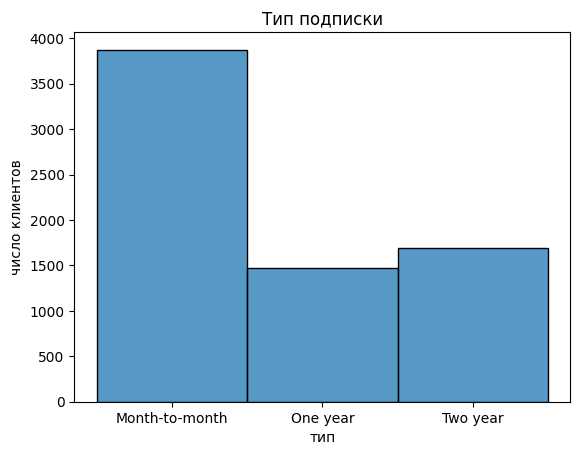

In [83]:
plt.figure()
sns.histplot(data['Type']).set(title='Тип подписки')

plt.xlabel('тип')
plt.ylabel('число клиентов')
plt.show()

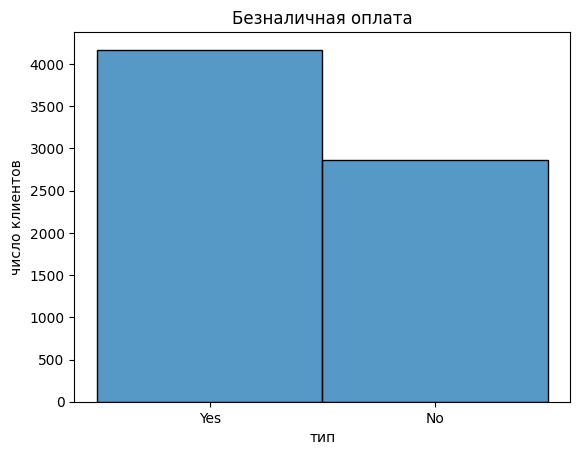

In [84]:
plt.figure()
sns.histplot(data['PaperlessBilling']).set(title='Безналичная оплата')

plt.xlabel('тип')
plt.ylabel('число клиентов')
plt.show()

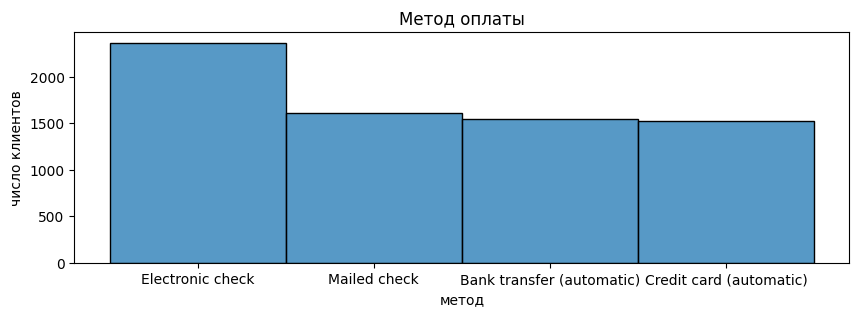

In [85]:
plt.figure(figsize=(10,3))
sns.histplot(data['PaymentMethod']).set(title='Метод оплаты')

plt.xlabel('метод')
plt.ylabel('число клиентов')
plt.show()

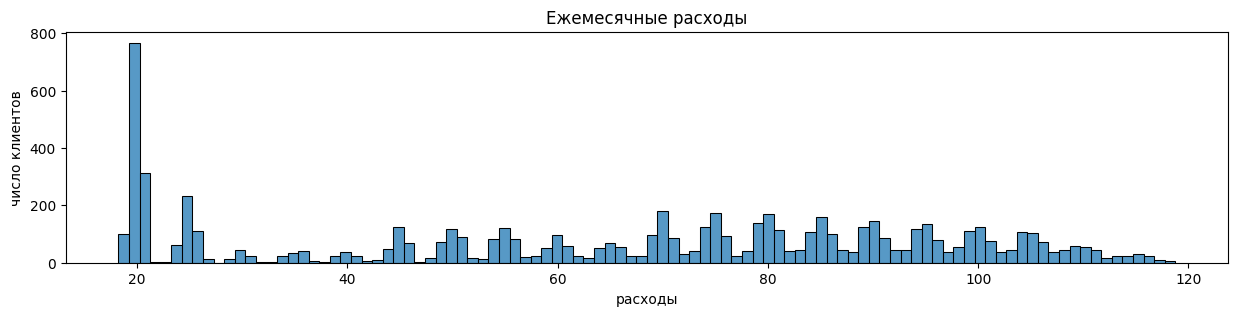

In [86]:
plt.figure(figsize=(15,3))
sns.histplot(data['MonthlyCharges'], bins=100).set(title='Ежемесячные расходы')

plt.xlabel('расходы')
plt.ylabel('число клиентов')
plt.show()

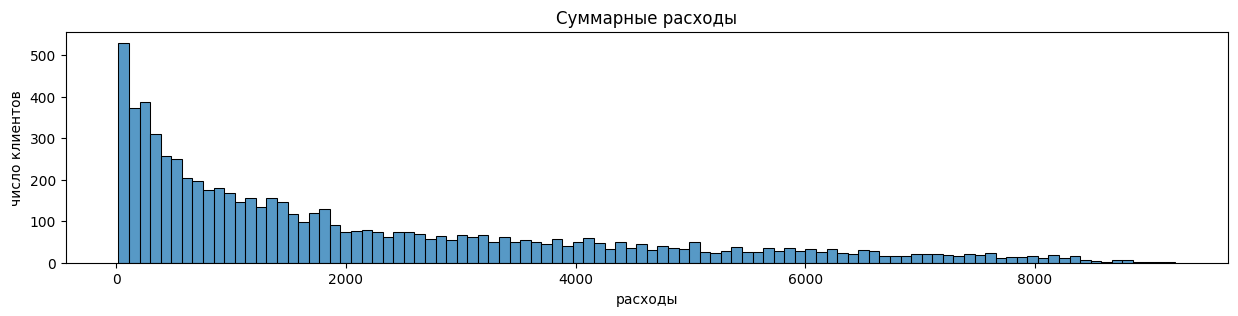

In [87]:
plt.figure(figsize=(15,3))
sns.histplot(data['TotalCharges'], bins=100).set(title='Суммарные расходы')

plt.xlabel('расходы')
plt.ylabel('число клиентов')
plt.show()

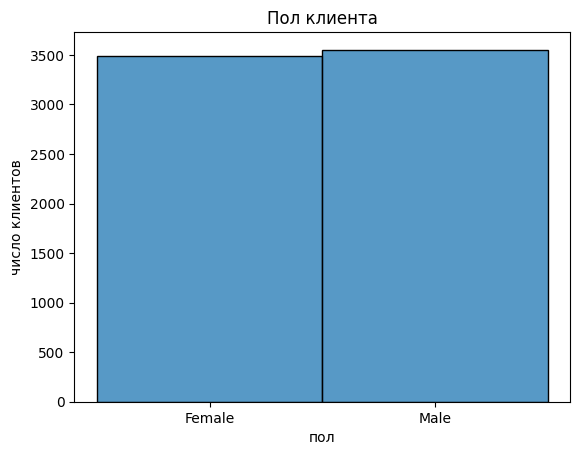

In [88]:
plt.figure()
sns.histplot(data['gender']).set(title='Пол клиента')

plt.xlabel('пол')
plt.ylabel('число клиентов')
plt.show()

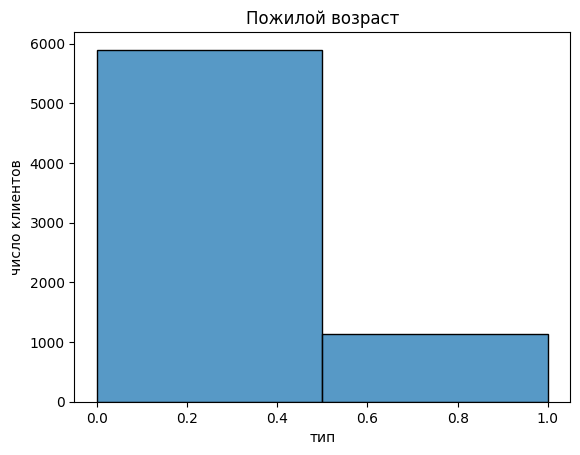

In [89]:
plt.figure()
sns.histplot(data['SeniorCitizen'], bins=2).set(title='Пожилой возраст')

plt.xlabel('тип')
plt.ylabel('число клиентов')
plt.show()

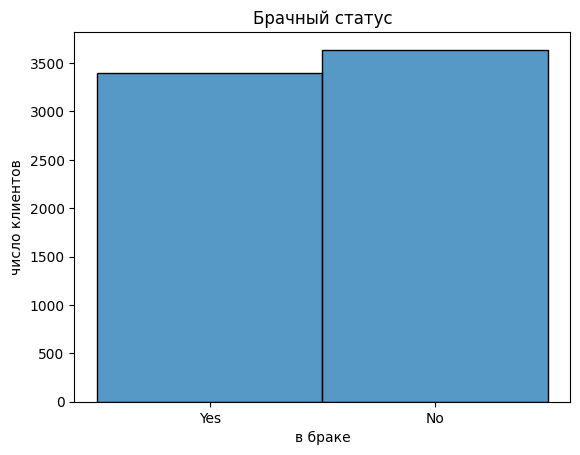

In [90]:
plt.figure()
sns.histplot(data['Partner']).set(title='Брачный статус')

plt.xlabel('в браке')
plt.ylabel('число клиентов')
plt.show()

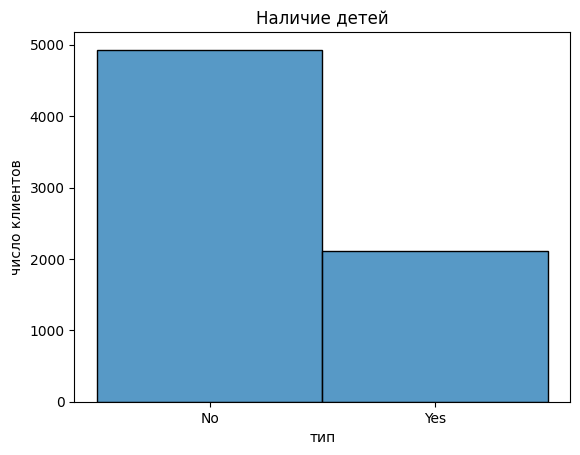

In [91]:
plt.figure()
sns.histplot(data['Dependents']).set(title='Наличие детей')

plt.xlabel('тип')
plt.ylabel('число клиентов')
plt.show()

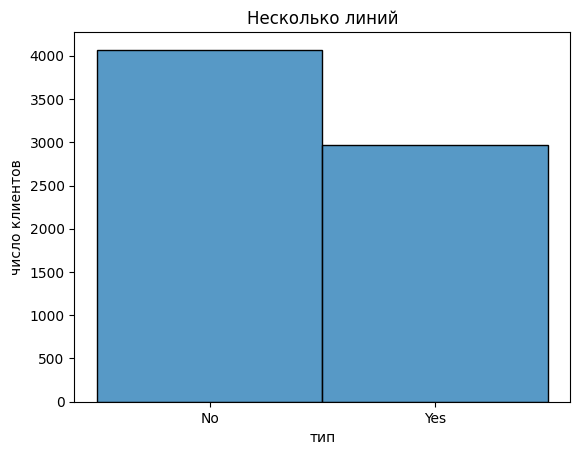

In [92]:
plt.figure()
sns.histplot(data['MultipleLines']).set(title='Несколько линий')

plt.xlabel('тип')
plt.ylabel('число клиентов')
plt.show()

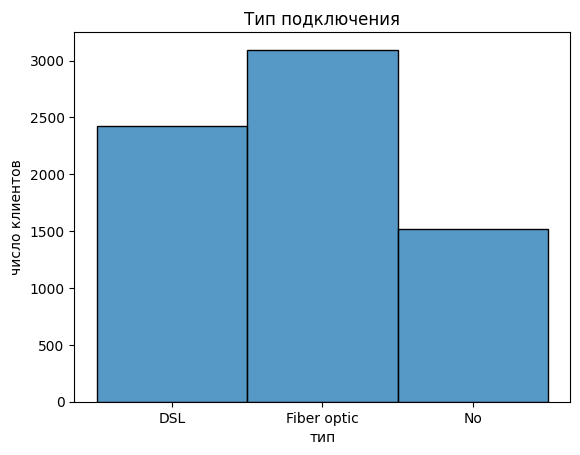

In [93]:
plt.figure()
sns.histplot(data['InternetService']).set(title='Тип подключения')

plt.xlabel('тип')
plt.ylabel('число клиентов')
plt.show()

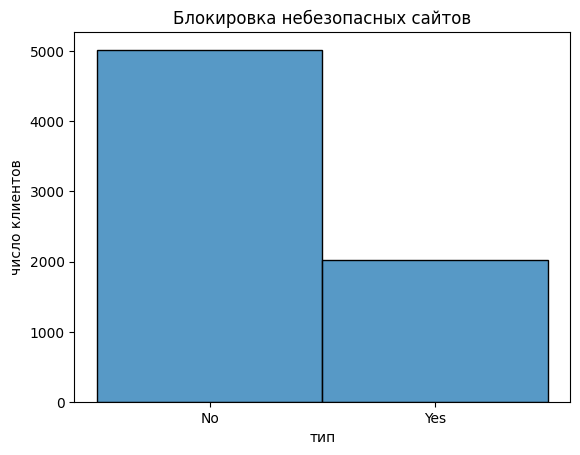

In [94]:
plt.figure()
sns.histplot(data['OnlineSecurity']).set(title='Блокировка небезопасных сайтов')

plt.xlabel('тип')
plt.ylabel('число клиентов')
plt.show()

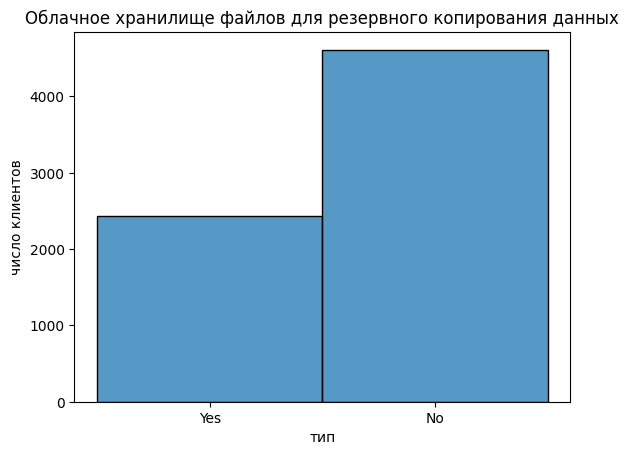

In [95]:
plt.figure()
sns.histplot(data['OnlineBackup']).set(title='Облачное хранилище файлов для резервного копирования данных')

plt.xlabel('тип')
plt.ylabel('число клиентов')
plt.show()

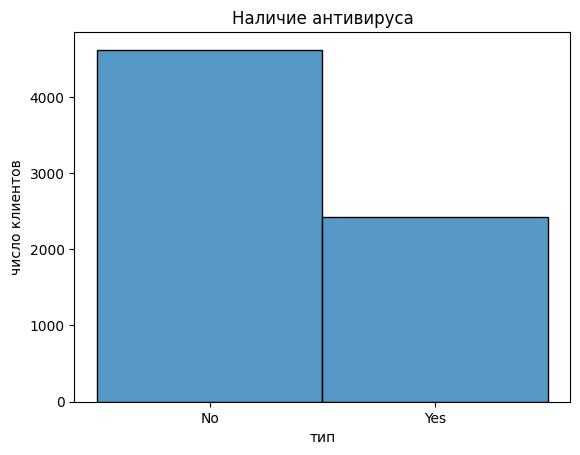

In [96]:
plt.figure()
sns.histplot(data['DeviceProtection']).set(title='Наличие антивируса')

plt.xlabel('тип')
plt.ylabel('число клиентов')
plt.show()

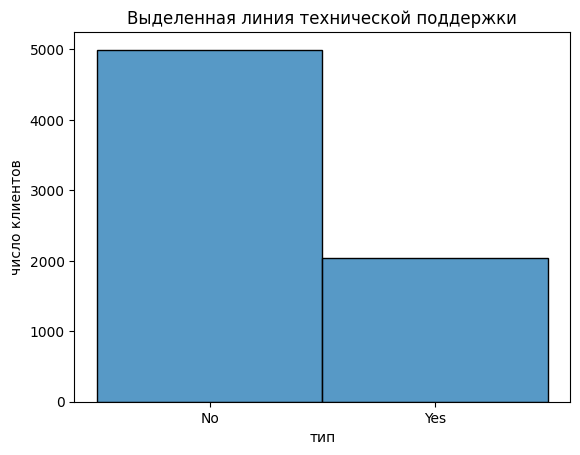

In [97]:
plt.figure()
sns.histplot(data['TechSupport']).set(title='Выделенная линия технической поддержки')

plt.xlabel('тип')
plt.ylabel('число клиентов')
plt.show()

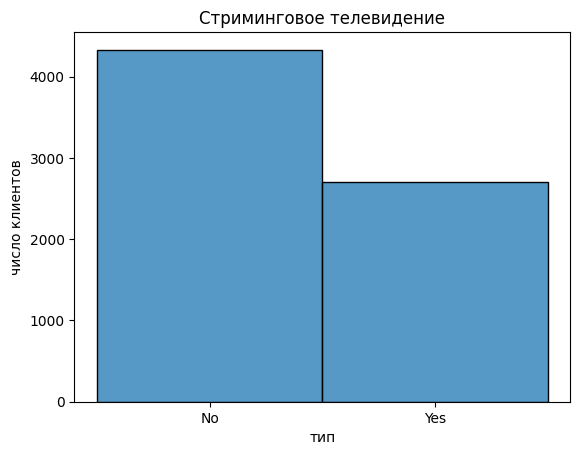

In [98]:
plt.figure()
sns.histplot(data['StreamingTV']).set(title='Стриминговое телевидение')

plt.xlabel('тип')
plt.ylabel('число клиентов')
plt.show()

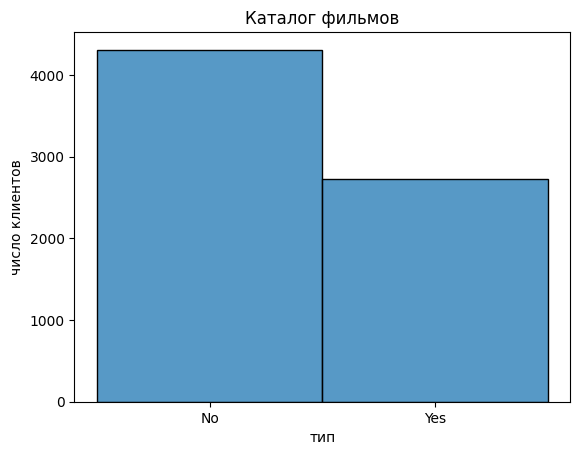

In [99]:
plt.figure()
sns.histplot(data['StreamingMovies']).set(title='Каталог фильмов')

plt.xlabel('тип')
plt.ylabel('число клиентов')
plt.show()

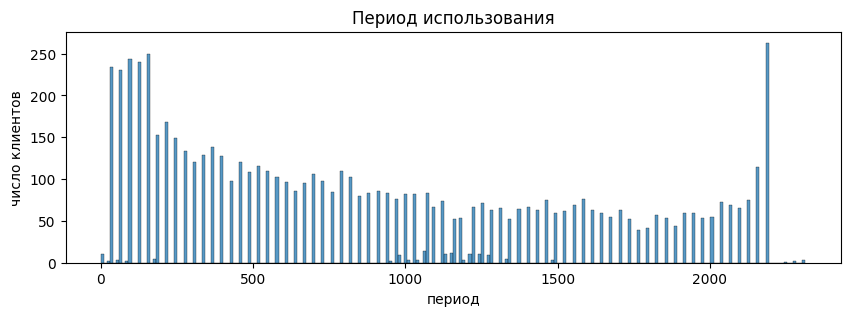

In [100]:
plt.figure(figsize=(10,3))
sns.histplot(data['UsePeriod'], bins=230).set(title='Период использования')

plt.xlabel('период')
plt.ylabel('число клиентов')
plt.show()

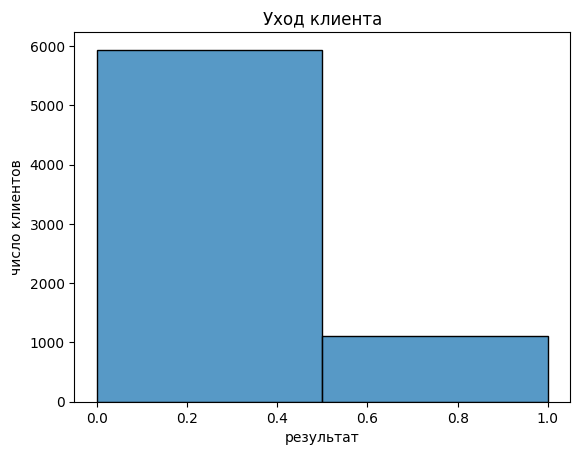

In [101]:
plt.figure()
sns.histplot(data['LostClient'], bins=2).set(title='Уход клиента')

plt.xlabel('результат')
plt.ylabel('число клиентов')
plt.show()

### Построим несколько графиков с отличиями для ушедших и оставшихся признаков:

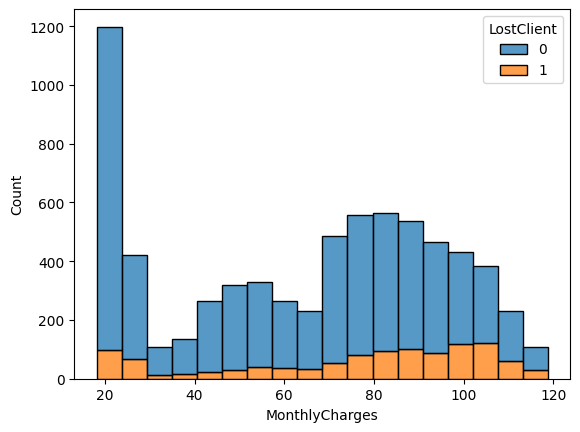

In [102]:
sns.histplot(data, x='MonthlyCharges', hue='LostClient', multiple="stack");

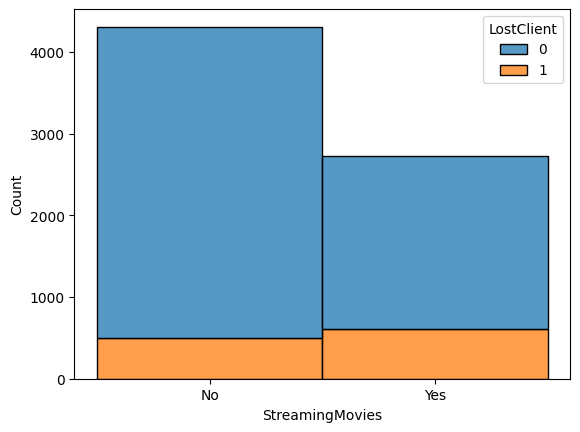

In [103]:
sns.histplot(data, x='StreamingMovies', hue='LostClient', multiple="stack");

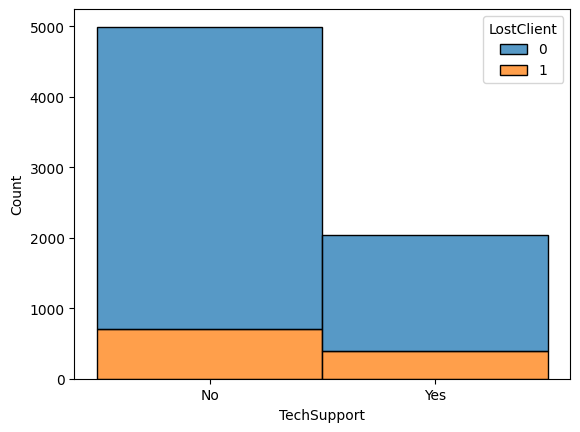

In [104]:
sns.histplot(data, x='TechSupport', hue='LostClient', multiple="stack");

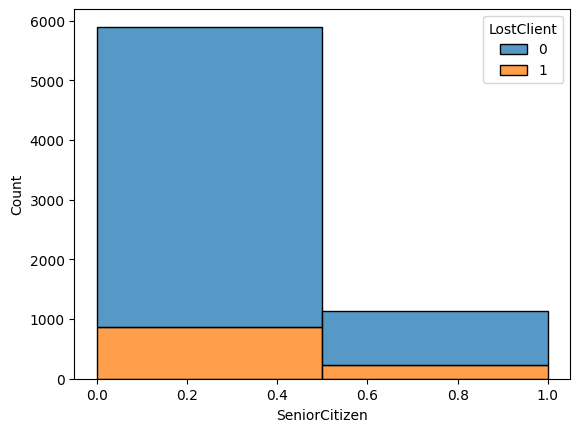

In [105]:
sns.histplot(data, x='SeniorCitizen', hue='LostClient', multiple="stack", bins=2);

### Изучим корреляцию признаков датасета

Получим матрицу фи-корреляции и выведем ее на экран:

In [106]:
phik_overview = data.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'UsePeriod', 'LostClient']


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,UsePeriod,LostClient
Type,1.00,0.11,0.28,0.39,0.47,0.00,0.09,0.18,0.15,0.07,0.51,0.15,0.10,0.14,0.18,0.07,0.07,0.63,0.09
PaperlessBilling,0.11,1.00,0.37,0.47,0.20,0.00,0.24,0.01,0.17,0.25,0.23,0.00,0.20,0.16,0.06,0.34,0.32,0.03,0.08
PaymentMethod,0.28,0.37,1.00,0.40,0.33,0.00,0.29,0.24,0.23,0.34,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.35,0.21
MonthlyCharges,0.39,0.47,0.40,1.00,0.71,0.01,0.30,0.20,0.19,0.68,0.92,0.55,0.63,0.67,0.58,0.84,0.83,0.39,0.23
TotalCharges,0.47,0.20,0.33,0.71,1.00,0.00,0.14,0.38,0.08,0.57,0.49,0.52,0.62,0.64,0.55,0.64,0.64,0.85,0.30
gender,0.00,0.00,0.00,0.01,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.01
SeniorCitizen,0.09,0.24,0.29,0.30,0.14,0.00,1.00,0.02,0.32,0.22,0.16,0.06,0.10,0.09,0.09,0.16,0.19,0.06,0.09
Partner,0.18,0.01,0.24,0.20,0.38,0.00,0.02,1.00,0.65,0.22,0.00,0.22,0.22,0.24,0.19,0.19,0.18,0.45,0.23
Dependents,0.15,0.17,0.23,0.19,0.08,0.00,0.32,0.65,1.00,0.03,0.11,0.12,0.03,0.01,0.10,0.02,0.06,0.20,0.05
MultipleLines,0.07,0.25,0.34,0.68,0.57,0.00,0.22,0.22,0.03,1.00,0.23,0.15,0.31,0.31,0.16,0.39,0.39,0.40,0.26


Изобразим полученную матрицу графически:

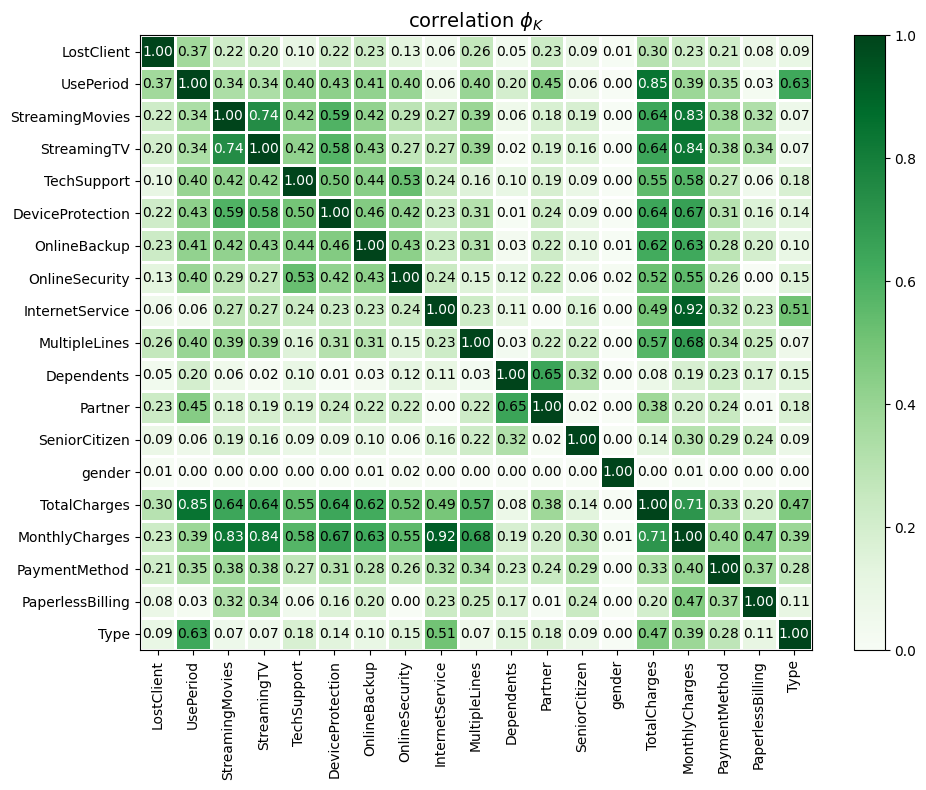

In [107]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1,
                        figsize=(10, 8))
plt.tight_layout()

### **Вывод:**

Для всех столбцов построены графики зависимости от числа клиентов:

1) Клиентов с одно- и двухгодичной подпиской почти поровну, а с ежемесячной - почти в 2,5 раза больше.

2) Клиентов, производящих безналичную оплату на 25% больше, чем платящих за сервис наличными.

3) В свою очередь, чеком по почте, банковским переводом и кредитной картой платит примерно поровну клиентов, а электронным чеком на 40% больше.

4) Ежемесячные расходы существенной части клиентов составляют около двадцати условных единиц. Остальные группы разделились отностительно равномерно на диапазоне от двадцати пяти до ста двадцати условных единиц.

5) Суммарные расходы существенной части клиентов состовляют около ста условных единиц; затем их значение плавно возрастает в обратной пропорции к числу клиентов.

6) Мужчин и женщин среди клиентов примерно одинаковое количество.

7) Клиентов пожилого возраста в шесть раз меньше, чем других возрастов.

8) Клиентов, состоящих в браке, лишь чуть меньше, чем незамужних.

9) А с детьми - в 2,5 раза меньше, чем без.

10) Клиентов, использующих несколько линий интернета, на четверть меньше.

11) Большая часть пользователей предпочитает опто-волокно; DSL - на втором месте. Приблизительно одна пятая клиентов вообще не пользуется интернетом.

12) Блокировку небезопасных сайтов приобретают лишь два человека из семи.

13) Облачное хранилище - примерно половина.

14) Так же обстоит дело и с антивирусом.

15) Выделенной линией тех поддержки пользуется чуть меньше половины пользователей.

16) Стриминговое телевидение есть у сорока процентов пользователей.

17) Так же и с каталогом фильмов.

18) Самые многочисленные группы по периоду использования сервиса лежат в интервале от одного до нескольких месяцев; или среди тех, кто продолжает пользоваться подпиской с самого начала сбора данных больше шести лет назад.

19) В общей сложности, каждый седьмой пользователь отказался от сервиса за период сбора данных.

20) Распределение ежемесячных расходов между оставшимися и ушедшими пользователями приблизительно одинаковое, за исключением категории, вносящей двадцать условных единиц в месяц - доля для оставшихся клиентов в несколько раз больше.

21) Каталогом фильмов пользовалось и не пользовалось примерно равное количество ушедших клиентов. В то время как среди оставшихся доля непользовавшихся выше.

22) Распределение по услуге выделенной линии тех поддержки у ушедших и оставшихся клиентов примерно одинаковое.

23) Так же ситуация обстоит и с наличием граждан пенсионного возраста среди ушедших и оставшихся клиентов.

Самая большая корреляция признаков наблюдается между ежемесячными расходами и наличием подключения к интернету, стримингового телевидения или каталога фильмов; а также, между периодом использования и суммарными расходами.

## Подготовка к обучению моделей

### Разобьем датасет на тренировочную и тестовую выборки

In [108]:
data_train, data_test = train_test_split(data, test_size=0.25, random_state=310723)

Выведем информацию о полученных выборках на экран:

In [109]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5279 entries, 0442-ZXKVS to 4024-CSNBY
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5279 non-null   object 
 1   PaperlessBilling  5279 non-null   object 
 2   PaymentMethod     5279 non-null   object 
 3   MonthlyCharges    5279 non-null   float64
 4   TotalCharges      5279 non-null   float64
 5   gender            5279 non-null   object 
 6   SeniorCitizen     5279 non-null   int64  
 7   Partner           5279 non-null   object 
 8   Dependents        5279 non-null   object 
 9   MultipleLines     5279 non-null   object 
 10  InternetService   5279 non-null   object 
 11  OnlineSecurity    5279 non-null   object 
 12  OnlineBackup      5279 non-null   object 
 13  DeviceProtection  5279 non-null   object 
 14  TechSupport       5279 non-null   object 
 15  StreamingTV       5279 non-null   object 
 16  StreamingMovies   5279 non-null 

In [110]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1760 entries, 6233-HXJMX to 6416-YJTTB
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              1760 non-null   object 
 1   PaperlessBilling  1760 non-null   object 
 2   PaymentMethod     1760 non-null   object 
 3   MonthlyCharges    1760 non-null   float64
 4   TotalCharges      1760 non-null   float64
 5   gender            1760 non-null   object 
 6   SeniorCitizen     1760 non-null   int64  
 7   Partner           1760 non-null   object 
 8   Dependents        1760 non-null   object 
 9   MultipleLines     1760 non-null   object 
 10  InternetService   1760 non-null   object 
 11  OnlineSecurity    1760 non-null   object 
 12  OnlineBackup      1760 non-null   object 
 13  DeviceProtection  1760 non-null   object 
 14  TechSupport       1760 non-null   object 
 15  StreamingTV       1760 non-null   object 
 16  StreamingMovies   1760 non-null 

### Закодируем категориальные признаки

In [112]:
transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', sparse=False),
        ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner',
         'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity',
         'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
         ]
    ),
    remainder='passthrough'
)

transformer.fit(data_train)
data_train = pd.DataFrame(transformer.transform(data_train), columns=transformer.get_feature_names_out())
display(data_train.head())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,onehotencoder__Type_One year,onehotencoder__Type_Two year,onehotencoder__PaperlessBilling_Yes,onehotencoder__PaymentMethod_Credit card (automatic),onehotencoder__PaymentMethod_Electronic check,onehotencoder__PaymentMethod_Mailed check,onehotencoder__gender_Male,onehotencoder__Partner_Yes,onehotencoder__Dependents_Yes,onehotencoder__MultipleLines_Yes,...,onehotencoder__OnlineBackup_Yes,onehotencoder__DeviceProtection_Yes,onehotencoder__TechSupport_Yes,onehotencoder__StreamingTV_Yes,onehotencoder__StreamingMovies_Yes,remainder__MonthlyCharges,remainder__TotalCharges,remainder__SeniorCitizen,remainder__UsePeriod,remainder__LostClient
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,115.60,6242.40,1.0,1645.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,89.20,5441.20,0.0,1857.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,19.60,774.59,0.0,1157.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,110.50,8158.22,0.0,2102.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,72.45,2245.95,0.0,945.0,0.0


In [113]:
data_test = pd.DataFrame(transformer.transform(data_test), columns=transformer.get_feature_names_out())
display(data_test.head())

,onehotencoder__Type_One year,onehotencoder__Type_Two year,onehotencoder__PaperlessBilling_Yes,onehotencoder__PaymentMethod_Credit card (automatic),onehotencoder__PaymentMethod_Electronic check,onehotencoder__PaymentMethod_Mailed check,onehotencoder__gender_Male,onehotencoder__Partner_Yes,onehotencoder__Dependents_Yes,onehotencoder__MultipleLines_Yes,...,onehotencoder__OnlineBackup_Yes,onehotencoder__DeviceProtection_Yes,onehotencoder__TechSupport_Yes,onehotencoder__StreamingTV_Yes,onehotencoder__StreamingMovies_Yes,remainder__MonthlyCharges,remainder__TotalCharges,remainder__SeniorCitizen,remainder__UsePeriod,remainder__LostClient
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,89.30,3214.8,0.0,1095.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,74.95,149.9,0.0,62.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,93.25,6714.0,0.0,2191.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,20.80,1206.4,0.0,1767.0,0.0
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,99.30,893.7,0.0,276.0,0.0


### Выделим из выборок признаки и целевой признак

In [115]:
target_train = data_train['remainder__LostClient']
features_train = data_train.drop(['remainder__LostClient'], axis=1)

In [116]:
target_test = data_test['remainder__LostClient']
features_test = data_test.drop(['remainder__LostClient'], axis=1)

### Масштабируем числовые признаки

Создадим копии признаков, обозначим, как предназначенные для использования в модели логистической регрессии (_lr) и выведем на экран:

In [117]:
features_train_lr = features_train.copy()

In [118]:
features_train_lr.head()

,onehotencoder__Type_One year,onehotencoder__Type_Two year,onehotencoder__PaperlessBilling_Yes,onehotencoder__PaymentMethod_Credit card (automatic),onehotencoder__PaymentMethod_Electronic check,onehotencoder__PaymentMethod_Mailed check,onehotencoder__gender_Male,onehotencoder__Partner_Yes,onehotencoder__Dependents_Yes,onehotencoder__MultipleLines_Yes,...,onehotencoder__OnlineSecurity_Yes,onehotencoder__OnlineBackup_Yes,onehotencoder__DeviceProtection_Yes,onehotencoder__TechSupport_Yes,onehotencoder__StreamingTV_Yes,onehotencoder__StreamingMovies_Yes,remainder__MonthlyCharges,remainder__TotalCharges,remainder__SeniorCitizen,remainder__UsePeriod
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,115.60,6242.40,1.0,1645.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,89.20,5441.20,0.0,1857.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,19.60,774.59,0.0,1157.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,110.50,8158.22,0.0,2102.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,72.45,2245.95,0.0,945.0


In [119]:
features_test_lr = features_test.copy()

In [120]:
features_test_lr.head()

,onehotencoder__Type_One year,onehotencoder__Type_Two year,onehotencoder__PaperlessBilling_Yes,onehotencoder__PaymentMethod_Credit card (automatic),onehotencoder__PaymentMethod_Electronic check,onehotencoder__PaymentMethod_Mailed check,onehotencoder__gender_Male,onehotencoder__Partner_Yes,onehotencoder__Dependents_Yes,onehotencoder__MultipleLines_Yes,...,onehotencoder__OnlineSecurity_Yes,onehotencoder__OnlineBackup_Yes,onehotencoder__DeviceProtection_Yes,onehotencoder__TechSupport_Yes,onehotencoder__StreamingTV_Yes,onehotencoder__StreamingMovies_Yes,remainder__MonthlyCharges,remainder__TotalCharges,remainder__SeniorCitizen,remainder__UsePeriod
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,89.30,3214.8,0.0,1095.0
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,74.95,149.9,0.0,62.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,93.25,6714.0,0.0,2191.0
3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,20.80,1206.4,0.0,1767.0
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,99.30,893.7,0.0,276.0


Произведем масштабирование их числовых признаков:

In [121]:
numeric = ['remainder__MonthlyCharges', 'remainder__TotalCharges', 'remainder__UsePeriod']

pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train_lr[numeric])
features_train_lr[numeric] = scaler.transform(features_train_lr[numeric])
features_test_lr[numeric] = scaler.transform(features_test_lr[numeric])

display(features_train_lr.head())

,onehotencoder__Type_One year,onehotencoder__Type_Two year,onehotencoder__PaperlessBilling_Yes,onehotencoder__PaymentMethod_Credit card (automatic),onehotencoder__PaymentMethod_Electronic check,onehotencoder__PaymentMethod_Mailed check,onehotencoder__gender_Male,onehotencoder__Partner_Yes,onehotencoder__Dependents_Yes,onehotencoder__MultipleLines_Yes,...,onehotencoder__OnlineSecurity_Yes,onehotencoder__OnlineBackup_Yes,onehotencoder__DeviceProtection_Yes,onehotencoder__TechSupport_Yes,onehotencoder__StreamingTV_Yes,onehotencoder__StreamingMovies_Yes,remainder__MonthlyCharges,remainder__TotalCharges,remainder__SeniorCitizen,remainder__UsePeriod
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.695275,1.961257,1.0,1.099235
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.820800,1.581278,0.0,1.410578
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.484636,-0.631918,0.0,0.382558
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.526342,2.869857,0.0,1.770385
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.265971,0.065892,0.0,0.071215


### **Вывод:**

Произведена разбивка датасета на тренировочную и тестовую выборки. Размер тестовой выборки 25%. Осуществлено кодирование категориальных признаков. Из выборок выделены признаки и целевой признак. Произведено масштабирование числовых признаков.

## Обучение моделей

### Случайный лес

Зададим диапазон и определим оптимальные количество оценщиков и глубину дерева для RandomForestClassifier при наибольшем значении ROC-AUC. Дополнительно определим значение Accuracy:

In [122]:
parameters = { 'n_estimators': range (1, 30),
              'max_depth': range (1, 30), }

In [124]:
scoring = ['accuracy', 'roc_auc']

clf = GridSearchCV(RandomForestClassifier(random_state=310723), parameters, cv=5, scoring=scoring, refit="roc_auc", n_jobs=-1)
clf.fit(features_train, target_train)

i = clf.best_index_
best_accuracy = clf.cv_results_['mean_test_accuracy'][i]

print('ROC-AUC лучшей модели: {}'.format(clf.best_score_))
print('Accuracy лучшей модели: {}'.format(best_accuracy))
print('Best parametes: {}'.format(clf.best_params_))

ROC-AUC лучшей модели: 0.821666507547555
Accuracy лучшей модели: 0.8571700416487147
Best parametes: {'max_depth': 7, 'n_estimators': 29}


### Логистическая регрессия

Определим значения ROC-AUC и accuracy для модели, обученной при помощи алгоритма Logistic Regression:

In [125]:
model = LogisticRegression(random_state=310723, solver='liblinear', max_iter=1000)
model.fit(features_train_lr, target_train)

roc_auc = cross_val_score(model, features_train_lr, target_train, cv=5, scoring='roc_auc').mean()
accuracy = cross_val_score(model, features_train_lr, target_train, cv=5, scoring='accuracy').mean()

print('ROC-AUC модели:' , roc_auc)
print('Accuracy модели:' , accuracy)

ROC-AUC модели: 0.7754793137175835
Accuracy модели: 0.8634216573316099


### Градиентный бустинг

Определим значения ROC-AUC и accuracy для модели, обученной при помощи алгоритма CatBoostClassifier:

In [126]:
model = CatBoostClassifier(random_state=310723, verbose=False)
model.fit(features_train, target_train, verbose=False)

roc_auc = cross_val_score(model, features_train, target_train, cv=5, scoring='roc_auc').mean()
accuracy = cross_val_score(model, features_train, target_train, cv=5, scoring='accuracy').mean()

print('ROC-AUC модели:' , roc_auc)
print('Accuracy модели:' , accuracy)

ROC-AUC модели: 0.8843688396966861
Accuracy модели: 0.8901319474364499


### **Вывод:**

Произведено обучение моделей на основе Случайного леса, Логистической регрессии и CatBoostClassifier. Наилучшим образом себя показала модель CatBoostClassifier. Значение ROC-AUC данной модели составило 0.88, а Accuracy - 0.89

## Проверка модели

Проверим модель на тестовой выборке:

In [127]:
model = CatBoostClassifier(random_state=310723, verbose=False)
model.fit(features_train, target_train, verbose=False)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

predictions_test = model.predict(features_test)

print('ROC-AUC модели:' , roc_auc_score(target_test, probabilities_one_test))
print('Accuracy модели:' , accuracy_score(target_test, predictions_test))

ROC-AUC модели: 0.8892273561774691
Accuracy модели: 0.8897727272727273


Построим график ROC-кривой:

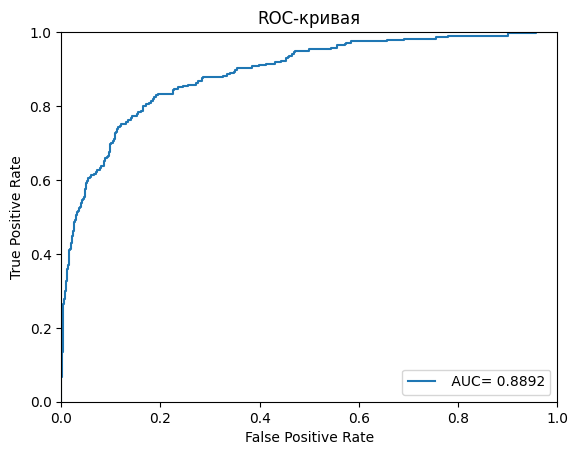

In [128]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

plt.plot(fpr, tpr, label=" AUC= "+str(round(roc_auc_score(target_test, probabilities_one_test), 4)))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc=4)
plt.show()

**Вывод:** При проверке на модели CatBoostClassifier на тестовой выборке значение ROC-AUC составило 0.8892, а Accuracy - 0.8898. Следовательно, данная модель может быть использована для выполнения задачи проекта.

## Общий вывод

Произведена загрузка и предварительный анализ данных четырех датасетов. Все четыре датасета содержат столбец customerID. По нему осуществлено их объединение в один файл под названием data.

1) В ходе предобработки значение тип столбца TotalCharges преобразован во float64. Создан новый столбец UsePeriod, как разность между EndDate и BeginDate. Также, создан столбец LostClient, показывающий ушел ли клиент от провайдера. Столбцы EndDate и BeginDate удалены из датасета.

Из датасета также удалены дубликаты. Произведена замена пропущенных значений: в столбце TotalCharges - значением столбца MonthlyCharges; в столбцах MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies - значением 'No'.

2) Для всех столбцов построены графики зависимости от числа клиентов:

Клиентов с одно- и двухгодичной подпиской почти поровну, а с ежемесячной - почти в 2,5 раза больше. Клиентов, производящих безналичную оплату на 25% больше, чем платящих за сервис наличными. В свою очередь, чеком по почте, банковским переводом и кредитной картой платит примерно поровну клиентов, а электронным чеком на 40% больше. Ежемесячные расходы существенной части клиентов составляют около двадцати условных единиц. Остальные группы разделились отностительно равномерно на диапазоне от двадцати пяти до ста двадцати условных единиц Суммарные расходы существенной части клиентов состовляют около ста условных единиц; затем их значение плавно возрастает в обратной пропорции к числу клиентов. Мужчин и женщин среди клиентов примерно одинаковое количество. Клиентов пожилого возраста в шесть раз меньше, чем других возрастов. Клиентов, состоящих в браке, лишь чуть меньше, чем незамужних. А с детьми - в 2,5 раза меньше, чем без. Клиентов, использующих несколько линий интернета, на четверть меньше. Большая часть пользователей предпочитает опто-волокно; DSL - на втором месте. Приблизительно одна пятая клиентов вообще не пользуется интернетом. Блокировку небезопасных сайтов приобретают лишь два человека из семи. Облачное хранилище - примерно половина. Так же обстоит дело и с антивирусом. Выделенной линией тех поддержки пользуется чуть меньше половины пользователей. Стриминговое телевидение есть у сорока процентов пользователей. Так же и с каталогом фильмов. Самые многочисленные группы по периоду использования сервиса лежат в интервале от одного до нескольких месяцев; или среди тех, кто продолжает пользоваться подпиской с самого начала сбора данных больше шести лет назад. В общей сложности, каждый седьмой пользователь отказался от сервиса за период сбора данных.

Распределение ежемесячных расходов между оставшимися и ушедшими пользователями приблизительно одинаковое, за исключением категории, вносящей двадцать условных единиц в месяц - доля для оставшихся клиентов в несколько раз больше. Каталогом фильмов пользовалось и не пользовалось примерно равное количество ушедших клиентов. В то время как среди оставшихся доля непользовавшихся выше. Распределение по услуге выделенной линии тех поддержки у ушедших и оставшихся клиентов примерно одинаковое. Так же ситуация обстоит и с наличием граждан пенсионного возраста среди ушедших и оставшихся клиентов.

3) Самая большая корреляция признаков наблюдается между ежемесячными расходами и наличием подключения к интернету, стримингового телевидения или каталога фильмов; а также, между периодом использования и суммарными расходами.

4) Произведена разбивка датасета на тренировочную и тестовую выборки. Размер тестовой выборки 25%. Осуществлено кодирование категориальных признаков. Из выборок выделены признаки и целевой признак. Произведено масштабирование числовых признаков.

5) Произведено обучение моделей на основе Случайного леса, Логистической регрессии и CatBoostClassifier. Наилучшим образом себя показала модель CatBoostClassifier. Значение ROC-AUC данной модели составило 0.88, а Accuracy - 0.89

6) При проверке на модели CatBoostClassifier на тестовой выборке значение ROC-AUC составило 0.8892, а Accuracy - 0.8898. Следовательно, данная модель может быть использована для выполнения задачи проекта - предсказания, уйдет клиент или нет.

## Отчет

В проекте требовалось построить модель для задачи классификации, которая предскажет, уйдет ли клиент от оператора связи.

**В ходе выполнения проекта были проделаны следующие шаги:**

*Предобработка данных:*

1) Импортированы необходимые библиотеки.

2) Задана дата выгрузки данных.

3) Датасеты загружены в соответствующие переменные и проверены на уникальные значения.

4) Все датасеты объеденены все в один по столбцу customerID и сохранены в переменную data.

5) Столбец customerID задан, как индекс всей таблицы.

6) Тип значений столбца TotalCharges преобразован в числовой, а столбца BeginDate - в тип datetime64.

7) Значения 'No' столбца EndDate заменены на дату выгрузки датафрейма.

8) Значения EndDate преобразованы в тип datetime64.

9) Создан новый столбец UsePeriod, как разность столбцов EndDate и BeginDate.

10) Столбец BeginDate удален из датасета.

11) На основе столбца EndDate cоздан новый столбец LostClient со значениями 0 или 1. Значения полученного столбца преобразованы в числовой тип.

12) Столбец EndDate удален из датасета.

13) Из датасета удалены дубликаты.

14) При помощи методов unique, value_counts и sort_values изучен каждый столбец в отдельности.

15) Пропущенные значения столбца TotalCharges заполнены соответсвующими значениями столбца MonthlyCharges.

16) Пропуски во всех остальных столбцах заполнены значением 'No'.



*Исследовательский анализ данных:*

1) Построены графики зависимости значений каждого столбца от числа клиентов.

2) Построены графики с отличиями для ушедших и оставшихся признаков.

3) Изучена корреляция признаков датасета: получена и изображена графически матрица фи-корреляции.

*Подготовка к обучению моделей:*

1) Датасет разделен на тренировочную и тестовую выборки **(test_size=0.25)**.

2) Закодированы категориальные признаки.

3) **Из выборок выделены признаки ('Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport' 'StreamingTV', 'StreamingMovies', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'UsePeriod') и целевой признак ('LostClient').**

4) Созданы копии признаков для использования в модели логистической регрессии и произведено масштабирование их числовых признаков.



*Обучение моделей:*

1) **Для всех моделей задан параметр random_state = 310723**

2) Задан диапазон (1, 30) и при помощи кросс-валидации (cv=5) определено оптимальное количество оценщиков (29) и глубина дерева (7) для RandomForestClassifier при наибольшем значении ROC-AUC. Дополнительно определено значение Accuracy.

3) При помощи кросс-валидации (cv=5) определены значения ROC-AUC и accuracy для модели, обученной алгоритмом Logistic Regression (solver='liblinear', max_iter=1000).

4) При помощи кросс-валидации (cv=5) определены значения ROC-AUC и accuracy для модели, обученной при помощи алгоритма CatBoostClassifier.

*Проверка модели:*

1) Модель CatBoostClassifier проверена на тестовой выборке. Значение ROC-AUC составило 0.8892, а Accuracy - 0.8898

2) Построен график ROC-кривой.

**Отличия от исходного плана работ:**

1) Объединение датасетов было перенесено в раздел "Предобработка данных". После него добавилась непосредственно сама предобработка.

2) В раздел "Исследовательский анализ данных" добавился пункт "Построение графиков с отличиями для ушедших и оставшихся признаков".

3) В раздел "Подготовка к обучению модели" добавился пункт "Выделение из выборок признаков и целевого признака".

4) В разделе "Обучение моделей" пункты поменялись местами. Итоговая последовательность: случайный лес - логистическая регрессия - градиентный бустинг.

5) В раздел "Проверка модели" добавился пункт "Построение графика ROC-кривой".

**В ходе выполнения проекта возникли следующие трудности:**

1) Подобрать, какими значениями заменить пропуски в столбце TotalCharges.

2) Написать код, чтобы GridSearchCV выдавал на выходе сразу две метрики.

**Ключевые этапы проекта:**

1) Предобработка данных.

2) Подготовка к обучению модели.

3) Обучение моделей.

4) Проверка модели.

**В качестве итоговой модели выбран CatBoostClassifier. Данная модель показала наилучший результат: значение ROC-AUC составило 0.88, а Accuracy - 0.89**